### Radio Data System

Process digital signals from FM radio stations. Information about radio station, program info, artist, song title can be extracted from the digital signal.
Some signal diagnostics are shown for help with development and realtime analysis.

In [1]:
#!/usr/bin/python3
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import decode
import pickle
import player
import rtlsdr
import numpy as np
import constants as co
import filters
import scipy.signal as sg
import multiprocessing #geeksforgeeks.com/multiprocessing


def demod(fm, g):

    bb = fm2bb(fm, g)
    bits = bb2bit(bb, g)

    return bits

def fm2bb(x, g):
    """Convert FM signal to Baseband"""
    bpf_57k = filters.bpf_57k()
    peak_19k = filters.peak_19k()
    lpf = filters.lpf()

    # Get Carrier to Demodulate
    x_19 = sg.filtfilt(peak_19k[0], peak_19k[1], x)
    x_57 = x_19**3
    #TODO BPF the CARRIER 57kHz
    #x_57 = sg.lfilter(bpf_57k[0], bpf_57k[1], x_57)

    # Demodulate, Filter, & Decimate
    x_bpf = sg.lfilter(bpf_57k[0], bpf_57k[1], x)
    x_bb = x_bpf * x_57
    x_bb_lpf = 1.3e3*sg.lfilter(lpf[0], lpf[1], x_bb)
    #bb_rrc = 100*sg.lfilter(rrc[0], rrc[1], bb_dec)
    x_bb_dec = x_bb_lpf[0::co.rds_dec]

    freq, fm = get_spec(x, 512)
    snr = calc_snr(fm, 512)

    g.spectrum(freq, fm, snr)
    g.scope(x_bpf=x_bpf, bb_lpf=x_bb_lpf)

    return x_bb_dec

def bb2bit(x, g):
    """Convert Baseband Signal to Bits"""
    sym_len = int(co.fs/co.fsym/co.rds_dec)
    sym_cnt = int(len(x)/sym_len)
    sym_list = [x[n*sym_len:n*sym_len+sym_len] for n in range(sym_cnt)]

    T = sym_len/2
    for sym in sym_list:
        T = sym_detect(T, np.abs(sym), sym_len/2)

    g.eye(sym_list, sym_len, T)

    bit_list = []
    for sym in sym_list:
        bit_list.append(sym[T])

    #bit_list = [sym[16::32] for sym in sym_list]
    bit_slice = [1 if i>0 else 0 for i in bit_list]
    bits = np.bitwise_xor(bit_slice[1:], bit_slice[:-1])
    return bits

def sym_detect(T, sym, sym_len):
    """Early-Late Detection"""
    d = 2   # small aperture

    if T + d >= sym_len:
        T = d + 1
    if T - d < 1:
        T = sym_len - d - 1

    T = int(T)
    if sym[T-d] > sym[T+d]:
        T -= d/2
    elif sym[T-d] < sym[T+d]:
        T += d/2

    return int(T)

def get_spec(x, n):
    F, X = sg.welch(x, fs=co.fs, nfft=n, return_onesided=True)
    XdB = 20 * np.log10(X)
    return F, XdB

def calc_snr(x, n):
    s_idx = int((co.fc+co.fsym)/co.fs*n)
    n_idx = int((co.fc+3*co.fsym)/co.fs*n)  # just outside rds bw
    S = x[s_idx]
    N = x[n_idx]
    return S - N

def recover_carrier(x):
    peak_19k = filters.peak_19k()
    y1 = sg.lfilter(peak_19k[0], peak_19k[1], x)
    y2 = sg.hilbert(y1) ** 3.0
    return y2

def recover_clock(x):
    clk = filters.clk()
    y0 = sg.lfilter(clk[0], clk[1], x)
    y1 = np.array(y0 > 0)
    return y1 - 0.5

def recover_symbols(clk, x):
    zero_xing = np.where(np.diff(np.sign(clk)))[0]
    #zero_xing = zero_xing[::2]
    zero_xing = zero_xing[0:-70:2]
    #y = x[zero_xing]
    y = x[zero_xing+25] #25, 31, 66
    amp = np.absolute(y)
    phz = np.angle(y)
    I = amp * np.cos(phz)
    Q = amp * np.sin(phz)
    #sym = (I > 0)
    sym = (Q > 0)
    return sym



In [2]:
def decoder(bits, g, rds):
    """Decode Bit Stream"""
    bit0 = decode.group_sync(bits)     # returns large number if not syncd

    for n in range(bit0, len(bits)-104, 104):
        frame = bits[n:n+104]
        line = (decode.unpack_frame(frame))
        rds.process_line(line)

    if rds.station_lock:
        g.text(rds.msg)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
import matplotlib.patches as pch

class Graph:

    def __init__(self):
        self.gs = grs.GridSpec(3,3, height_ratios=[4,4,1])

    def clf(self):
        plt.clf()

    def run(self):
        print('plot')
        plt.show()
        
        #plt.pause(0.5)

    def scope(self, **kwargs):
        self.x_bpf = kwargs['x_bpf']
        self.bb_lpf = kwargs['bb_lpf']
        a = 6000
        b = a + 960*2
        delay = 40

        self.time = range(200, len(self.x_bpf)-200)
        self.x_bpf = self.x_bpf[200-delay:-200-delay]
        self.bb_lpf = self.bb_lpf[200:-200]

        ax = plt.subplot(self.gs[0, :])
        ax.plot(self.time, self.x_bpf, c='C1')
        ax.plot(self.time, self.bb_lpf, c='C0', lw=1.8)
        ax.set_xlim([a, b])
        ax.set_ylim([-0.2, 0.2])

    def spectrum(self, freq, x, snr):

        x_max = np.max(x) + 20

        # Rect((left,bottom), width, height)
        rds_patch = pch.Rectangle((57-2.4,-140), 4.8, 200, alpha=0.4, facecolor='m')

        ax = plt.subplot(self.gs[1, 1])
        ax.plot(freq*1e-3, x)
        ax.text(80, x_max-5, 'SNR=%.1fdB' % (snr,), fontsize=10)
        ax.set_ylim(bottom=-140, top=x_max)
        ax.add_patch(rds_patch)

    def eye(self, sym_list, sym_len, o):
        # only plot a few, it takes a long time to plot >1000
        ax = plt.subplot(self.gs[1,0])
        ax.set_ylim(-0.2, 0.2)
        for sym in sym_list[::10]:
            ax.plot(range(0,int(sym_len)), sym, c='C0', alpha=0.5)
        ax.plot([o,o],[-1,1], c='C2', lw=2)

    def constellation(self, i, q, rate):
        self.i = i
        self.q = q
        ax = plt.subplot(self.gs[1,2])
        ax.plot(self.i, self.q, ls='None', marker='.', alpha=0.5)

    def text(self, msg):
        pi, pt, gt, ps, rt, cnt = msg
        ax = plt.subplot(self.gs[2, 0])
        plt.axis('off')
        plt.text(0, 0.8, 'PS: {}'.format(ps), size=20)
        plt.text(0, 0.2, 'RT: {}'.format(rt), size=20)
        ax = plt.subplot(self.gs[2, 1])
        plt.axis('off')
        plt.text(0.5, 0.8, '{} - {}'.format(
            pi, pt), size=20, horizontalalignment='center')
        ax = plt.subplot(self.gs[2, 2])
        plt.axis('off')
        plt.text(1, 0.8, 'CNT: {}'.format(
            cnt), size=20, horizontalalignment='right')

def response(taps):
    b = taps[0]
    a = taps[1]
    w, h = sg.freqz(b,a)
    frq = w/np.pi/2 * constants.fs/1e3
    amp = 20*np.log10(abs(h))
    phz = np.unwrap(np.angle(h))*180/np.pi

    _, ax = plt.subplots()
    ax.plot(frq, amp, lw=0.7)
    ax2 = ax.twinx()
    ax2.plot(frq, phz, c='C2', ls='--', lw=0.7)
    plt.show(block=False)

    plt.plot([0,0], [-1, 1], 'C0')


plot


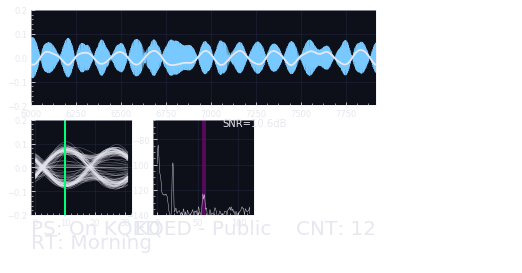

plot


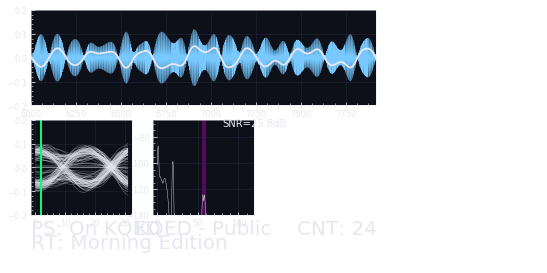

plot


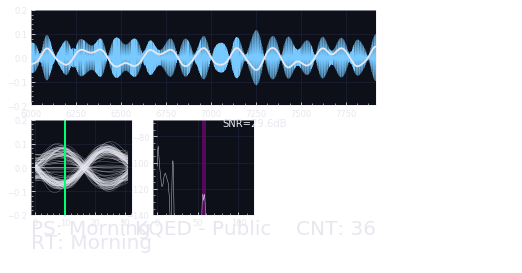

plot


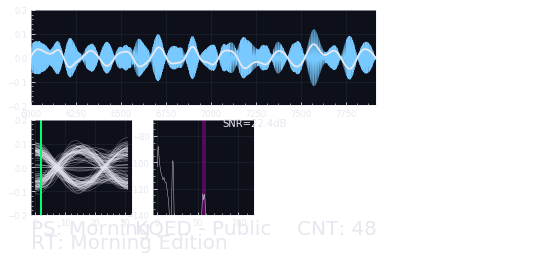

In [4]:
#audio_que = multiprocessing.Queue()
demod_que = multiprocessing.Queue()

def receive(que):
    #TODO: move to fmrx
    g = Graph()
    rds = decode.RDS()      #<<< this is called only once
    while True:
        data = que.get(timeout=5)
        if data is None:
            break

        g.clf()
        bits = demod(data, g)
        decoder(bits, g, rds)
        g.run()
        
def process_samples(samples):
    fm = demod_fm(samples)
    #audio_que.put(fm)
    demod_que.put(fm)

def demod_fm(x):
    x = x[1:] * np.conj(x[:-1])
    fm = np.angle(x)
    return fm


def read_file(filename):
    """Open file and parse multiple sample sets"""
    with open(filename, 'rb') as f:
        samples = pickle.load(f)

    data_list = [list(n) for n in samples]

    for data in data_list:
        process_samples(data)
        
#audio_proc = multiprocessing.Process(target=player.receive, args=(audio_que,))
demod_proc = multiprocessing.Process(target=receive, args=(demod_que,))

#audio_proc.start()
demod_proc.start()

# Only read local file here. See real code for RTL-SDR interface.
read_file('../samples/rds_file_py3')

#audio_que.put(None)
demod_que.put(None)

#audio_proc.join()
demod_proc.join()